In [1]:
import datetime
from dateutil.parser import parse

import getpass

from IPython.core.display import display, HTML

import numpy as np
from pandas import pandas

from storyboardclient.v1 import client
api_url="https://storyboard.openstack.org/api/v1"

display(HTML('Get a token from: <a href="https://storyboard.openstack.org/#!/profile/tokens">https://storyboard.openstack.org/#!/profile/tokens</a></body>'))
access_token = getpass.getpass('Enter token:')

storyboard = client.Client(api_url, access_token)

storyboard.stories.get(1).id

Enter token: ····································


1

In [2]:
# Get all stories
stories = storyboard.stories.get_all()
print('Number of stories', len(stories))

# Get all tasks
tasks = storyboard.tasks.get_all()
print('Number of tasks', len(tasks))

# get all users
users = storyboard.users.get_all()
print('Number of users', len(users))

Number of stories 27859
Number of tasks 38325
Number of users 6760


In [3]:
# Create dicts for stories, tasks and users
users_dict = {}
for u in users:
    users_dict[u.id] = u.to_dict() 

stories_dict = {}
for s in stories:
    stories_dict[s.id] = s.to_dict()
    if s.creator_id is None:
        stories_dict[s.id]['creator_name'] = 'UNKNOWN'
    else:
        stories_dict[s.id]['creator_name'] = users_dict[s.creator_id]['full_name']

tasks_dict = {}
for t in tasks:
    tasks_dict[t.id] = t.to_dict()
    if t.creator_id is None:
        tasks_dict[t.id]['creator_name'] = stories_dict[t.story_id]['creator_name']
    else:
        tasks_dict[t.id]['creator_name'] = users_dict[t.creator_id]['full_name']
    if t.assignee_id is None:
        tasks_dict[t.id]['assignee_name'] = 'UNKNOWN'
    else:
        tasks_dict[t.id]['assignee_name'] = users_dict[t.assignee_id]['full_name']

In [4]:
#stories_dict[2006738]

In [5]:
#tasks_dict[1]

In [6]:
# Get the project group to work with
project_group_name = 'magnum'

project_group = storyboard.project_groups.find(name=project_group_name)

project_ids = [ project.id for project in project_group.projects.list() ]
project_names = [ project.name for project in project_group.projects.list() ]
projects = {}
for project in project_group.projects.list():
    projects[project.id] = project.name


In [7]:
def histogram_of_tasks(tasks):
    task_counts = {}
    for pn in project_names:
        task_counts[pn] = {}
    for t in tasks_in_group:
        project_name = projects[t['project_id']]
        task_counts[project_name][t['status']] = task_counts[project_name].get(t['status'], 0) + 1
    return task_counts

def print_task_with_url(task_id):
    task = tasks_dict[task_id]
    story_id = tasks_dict[task_id]['story_id']
    story_title = stories_dict[story_id]['title']
    msg = str(task_id)
    msg += ' <a href="https://storyboard.openstack.org/#!/story/'
    msg += str(story_id) + '">' + story_title + '</a></body>'
    display(HTML(msg))

def is_task_open(id):
    if tasks_dict[id]['status'] not in ['invalid', 'merged']:
        return True
    else:
        return False

def days_since_updated(id):
    if id in stories_dict:
        story_id = id
    else:
        story_id = tasks_dict[id]['story_id']

    updated_at = parse(stories_dict[story_id]['updated_at']).replace(tzinfo=None)
    now = datetime.datetime.now().replace(tzinfo=None)
    delta = now - updated_at
    return delta.days

In [8]:
# Get all tasks affecting the above project group
tasks_in_group = []
tasks_in_group_dict = {}

for t in tasks:
    if t.project_id in project_ids:
        tasks_in_group.append(tasks_dict[t.id])
        tasks_in_group_dict[t.id] = tasks_dict[t.id]
print('all tasks:', len(tasks_in_group))

open_tasks_in_group = []
open_tasks_in_group_dict = {}
for t in tasks_in_group:
    if is_task_open(t['id']):
        open_tasks_in_group.append(t)
        open_tasks_in_group_dict[t['id']] = t
print('open tasks:', len(open_tasks_in_group))

all tasks: 2392
open tasks: 391


In [9]:
#histogram_of_tasks(tasks_in_group)

In [10]:
d = {}
for id, t in open_tasks_in_group_dict.items():
    if days_since_updated(id) < 180:
        d[id] = t
df = pandas.DataFrame.from_dict(d, orient='index')
df_grouped = df.groupby(['creator_name'])['id'].count()
df2 = df_grouped.sort_values(ascending=False)

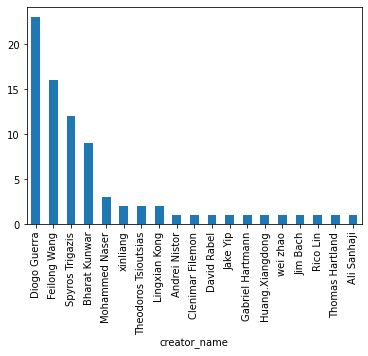

In [11]:
#df2.tail(20).plot.bar()
df2.plot.bar()

In [12]:
df2

creator_name
Diogo Guerra            23
Feilong Wang            16
Spyros Trigazis         12
Bharat Kunwar            9
Mohammed Naser           3
xinliang                 2
Theodoros Tsioutsias     2
Lingxian Kong            2
Andrei Nistor            1
Clenimar Filemon         1
David Rabel              1
Jake Yip                 1
Gabriel Hartmann         1
Huang.Xiangdong          1
wei zhao                 1
Jim Bach                 1
Rico Lin                 1
Thomas Hartland          1
Ali Sanhaji              1
Name: id, dtype: int64